Rice is amongst the widely consumed food in the world with the total consumption of 493.13 million metric tons in 2019–2020 and 486.62 in the year 2018–2019.

The rice leaves related diseases often pose threats to the sustainable production of rice affecting many farmers around the world. Early diagnosis and appropriate remedy of the rice leaf infection is crucial in facilitating healthy growth of the rice plants to ensure adequate supply and food security to the rapidly increasing population. Therefore, machine-driven disease diagnosis systems could mitigate the limitations of the conventional methods for leaf disease diagnosis techniques that is often time-consuming, inaccurate, and expensive.

The dataset has 119 images in total with images belonging to 3 classes : 1) Bacterial blight 2) Brown Spot 3) Leaf Smut.
Each classes has 40 images each except for leaf smut which has 39 images

**Bacterial blight**: Bacterial blight is caused by Xanthomonas oryzae pv. oryzae. 
It causes wilting of seedlings and yellowing and drying of leaves.The disease is most likely to develop in areas that have weeds and stubbles of infected plants. It can occur in both tropical and temperate environments, particularly in irrigated and rainfed lowland areas. In general, the disease favors temperatures at 25−34°C, with relative humidity above 70%.
Check for wilting and yellowing of leaves, or wilting of seedlings (also called kresek).On seedlings, infected leaves turn grayish green and roll up. As the disease progresses, the leaves turn yellow to straw-colored and wilt, leading whole seedlings to dry up and die.

**Brown Spot**: Brown spot is a fungal disease that infects the coleoptile, leaves, leaf sheath, panicle branches, glumes, and spikelets. The disease can develop in areas with high relative humidity (86−100%) and temperature between 16 and 36°C. It is common in unflooded and nutrient-deficient soil, or in soils that 
accumulate toxic substances.

For infection to occur, the leaves must be wet for 8−24 hours.

The fungus can survive in the seed for more than four years and can spread from plant to plant through air. Major sources of brown spot in the field include:

infected seed, which give rise to infected seedlings
volunteer rice
infected rice debris
weeds

For rice brown spot disease, the spots are initially small round, dark brown to purplish brown, and fully developed spots are round to elliptic with light brown to gray centers and reddish-brown edges.

**Leaf Smut**:smut causes chalkiness of grains which leads to reduction in grain weight. It also reduces seed germination.
The pathogen is fungal that infects rice flowers and turns them into rice false smut balls, which are the only visible feature of rice false smut.
The disease can occur in areas with high relative humidity (>90%) and temperature ranging from 25−35 ºC.Rain, high humidity, and soils with high nitrogen content also favors disease development. Wind can spread the fungal spores from plant to plant.

False smut is visible only after panicle exsertion. It can infect the plant during flowering stage.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pathlib
import warnings 
warnings.filterwarnings('ignore')

Get batches of images from the directory/subdirectory

In [29]:
IMAGE_HEIGHT =255
IMAGE_WIDTH = 255
batch_size =9
channel=3
epoch=15
dataset=tf.keras.preprocessing.image_dataset_from_directory( "/content/drive/MyDrive/MyDrive/Data",
                                                    shuffle=True,
                                                    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
                                                    batch_size=batch_size)

Found 119 files belonging to 3 classes.


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
class_names=dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

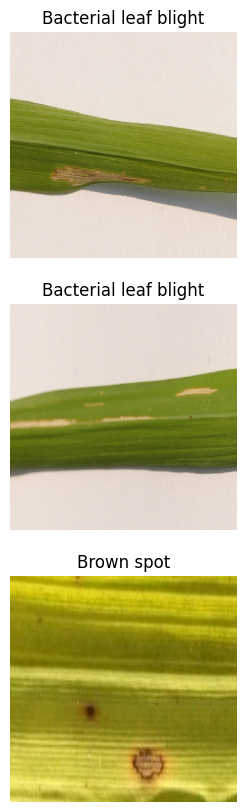

In [6]:
plt.figure(figsize=(10,10))
for image,label in dataset.take(1):
    for i in range(3):
        plt.subplot(3,1,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

Split the train test and validation dataset

In [30]:
def get_dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_Size=1000):
    
    ds_size=len(ds)
    print(len(ds))
    if shuffle:
        ds = ds.shuffle(shuffle_Size,seed=12)
    train_size = int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds =ds.skip(train_size).skip(val_size)
    return train_ds, test_ds,val_ds

In [31]:
train_ds, test_ds,val_ds = get_dataset_partitions_tf(dataset)

14


Cache and prefetch the dataset which will save some operations from being executd during each epoch

In [32]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Data normalization or rescale and resizing involves transforming the pixel values of the input images so that they fall within a specific range, typically [0, 1].By scaling the pixel values, normalization also makes it easier for the neural network to learn the underlying patterns in the data. This is because the weights in the neural network can be updated more easily and quickly when the input data has a similar scale.

In [33]:
 resize_and_rescale=tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT,IMAGE_WIDTH),
  layers.experimental.preprocessing.Rescaling(1.0/255)
 ])

Data augmentation is the process of broadening the dataset to enhance the model’s performance by generating different forms of images.
With the help of data augmentation, more images are generated from each image to train the model since some relevant or irrelevant patterns may be visible during the training process of the model. 
Randomly flips(horizontal and vertical) the images and rotational transformations are applied on them and multiple new images are generated from a single image.

In [34]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [35]:
input_shape=(batch_size, IMAGE_HEIGHT,IMAGE_WIDTH,channel)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
        layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(63,activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history= model.fit(
    train_ds,
    epochs=75,
    
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/75
11/11 [==============================] - 44s 946ms/step - loss: 1.1385 - accuracy: 0.3370 - val_loss: 1.1135 - val_accuracy: 0.3333
Epoch 2/75
11/11 [==============================] - 8s 712ms/step - loss: 1.0981 - accuracy: 0.3478 - val_loss: 1.1232 - val_accuracy: 0.3333
Epoch 3/75
11/11 [==============================] - 5s 485ms/step - loss: 1.1023 - accuracy: 0.3152 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 4/75
11/11 [==============================] - 5s 484ms/step - loss: 1.0864 - accuracy: 0.4022 - val_loss: 1.0861 - val_accuracy: 0.3333
Epoch 5/75
11/11 [==============================] - 7s 593ms/step - loss: 1.0630 - accuracy: 0.3587 - val_loss: 1.0601 - val_accuracy: 0.3333
Epoch 6/75
11/11 [==============================] - 7s 687ms/step - loss: 1.0440 - accuracy: 0.3370 - val_loss: 1.1118 - val_accuracy: 0.2222
Epoch 7/75
11/11 [==============================] - 5s 476ms/step - loss: 1.0755 - accuracy: 0.3261 - val_loss: 1.0202 - val_accuracy: 0.4444
Epoch

In [38]:
  score= model.evaluate(test_ds)

2/2 [==============================] - 3s 223ms/step - loss: 0.7992 - accuracy: 0.8333


In [39]:
    score= model.evaluate(train_ds)

11/11 [==============================] - 1s 123ms/step - loss: 0.2584 - accuracy: 0.9022


In [40]:
score= model.evaluate(val_ds)

1/1 [==============================] - 0s 130ms/step - loss: 0.5515 - accuracy: 0.7778


In [41]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

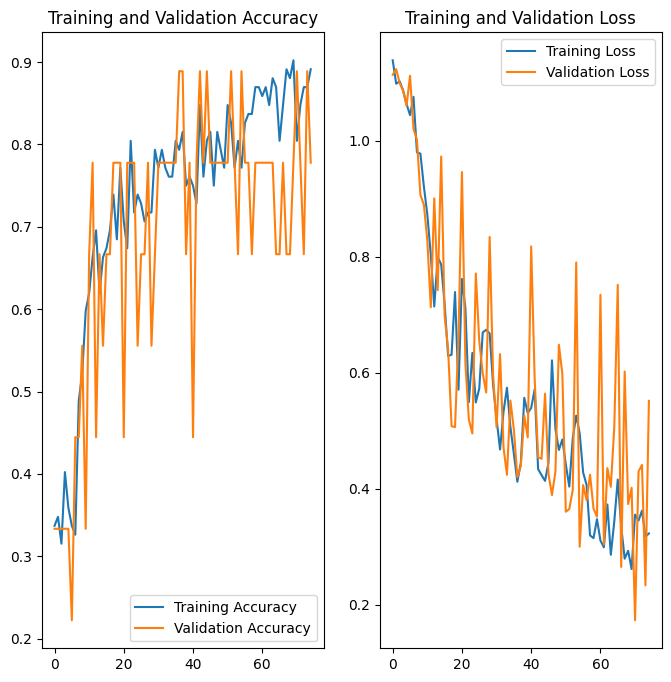

In [42]:
EPOCHS=75
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [43]:
import numpy as np
def prediction(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) 
  predict=model.predict(img_array)
  predicted_class = class_names[np.argmax(predict[0])]
  confidence= round(100*(np.max(predict[0])),2)
  return predicted_class,confidence


1/1 [==============================] - 0s 41ms/step


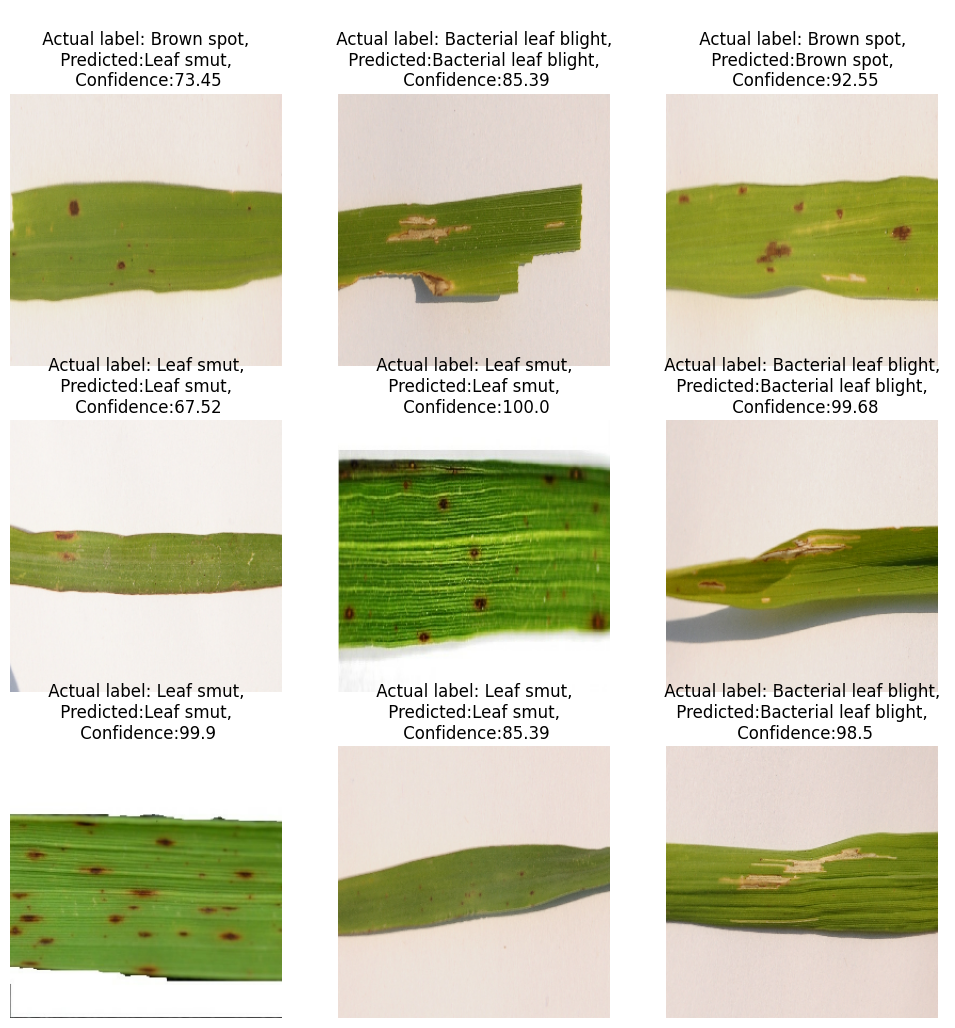

In [47]:
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
     for i in range(9):
           ax = plt.subplot(3,3,i+1)
           plt.imshow(images[i].numpy().astype('uint8'))
           predicted_class,confidence = prediction(model, images[i].numpy())
           actual_class = class_names[labels[i]]
           plt.title(f' \n Actual label: {actual_class}, \n Predicted:{predicted_class}, \n Confidence:{confidence}' )
           plt.axis('off')

#### Model with AdaGrad optimizer

In [48]:
model.compile(
    optimizer='AdaGrad',
    loss='SparseCategoricalCrossentropy',
    metrics=['accuracy'])

In [49]:
history= model.fit(
    train_ds,
    epochs=50,
    
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/50
11/11 [==============================] - 9s 720ms/step - loss: 0.2738 - accuracy: 0.8804 - val_loss: 0.2884 - val_accuracy: 0.8889
Epoch 2/50
11/11 [==============================] - 5s 478ms/step - loss: 0.1733 - accuracy: 0.9348 - val_loss: 0.1181 - val_accuracy: 1.0000
Epoch 3/50
11/11 [==============================] - 8s 703ms/step - loss: 0.2003 - accuracy: 0.9348 - val_loss: 0.1702 - val_accuracy: 1.0000
Epoch 4/50
11/11 [==============================] - 5s 485ms/step - loss: 0.1969 - accuracy: 0.9130 - val_loss: 0.2323 - val_accuracy: 0.8889
Epoch 5/50
11/11 [==============================] - 7s 608ms/step - loss: 0.2550 - accuracy: 0.8478 - val_loss: 0.1316 - val_accuracy: 1.0000
Epoch 6/50
11/11 [==============================] - 6s 550ms/step - loss: 0.1968 - accuracy: 0.9565 - val_loss: 0.1694 - val_accuracy: 1.0000
Epoch 7/50
11/11 [==============================] - 8s 703ms/step - loss: 0.1591 - accuracy: 0.9348 - val_loss: 0.1663 - val_accuracy: 1.0000
Epoch 

In [51]:
score= model.evaluate(test_ds)

2/2 [==============================] - 0s 143ms/step - loss: 1.0126 - accuracy: 0.8889


In [52]:
score= model.evaluate(train_ds)

11/11 [==============================] - 2s 164ms/step - loss: 0.1409 - accuracy: 0.9457


In [53]:
score= model.evaluate(val_ds)

1/1 [==============================] - 0s 299ms/step - loss: 0.1088 - accuracy: 1.0000


Train,test and validation accuracy did improve using AdaGrad optimizer

### Model with RMSProp optimizer

In [54]:
model.compile(
    optimizer='RMSProp',
    loss='SparseCategoricalCrossentropy',
    metrics=['accuracy'])

In [55]:
history= model.fit(
    train_ds,
    epochs=75,
    
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/75
11/11 [==============================] - 9s 713ms/step - loss: 0.5891 - accuracy: 0.7717 - val_loss: 0.3546 - val_accuracy: 0.7778
Epoch 2/75
11/11 [==============================] - 6s 503ms/step - loss: 0.2228 - accuracy: 0.8913 - val_loss: 0.1483 - val_accuracy: 1.0000
Epoch 3/75
11/11 [==============================] - 5s 475ms/step - loss: 0.2608 - accuracy: 0.8804 - val_loss: 0.7409 - val_accuracy: 0.6667
Epoch 4/75
11/11 [==============================] - 8s 703ms/step - loss: 0.5085 - accuracy: 0.8261 - val_loss: 0.5227 - val_accuracy: 0.7778
Epoch 5/75
11/11 [==============================] - 5s 483ms/step - loss: 0.2202 - accuracy: 0.9457 - val_loss: 0.1861 - val_accuracy: 0.8889
Epoch 6/75
11/11 [==============================] - 8s 711ms/step - loss: 0.2230 - accuracy: 0.9130 - val_loss: 0.2477 - val_accuracy: 0.7778
Epoch 7/75
11/11 [==============================] - 5s 525ms/step - loss: 0.4208 - accuracy: 0.8478 - val_loss: 0.2450 - val_accuracy: 0.8889
Epoch 

In [56]:
score= model.evaluate(test_ds)

2/2 [==============================] - 0s 129ms/step - loss: 1.3833 - accuracy: 0.8333


In [57]:
score= model.evaluate(train_ds)

11/11 [==============================] - 1s 125ms/step - loss: 0.1142 - accuracy: 0.9457


In [58]:
score= model.evaluate(val_ds)

1/1 [==============================] - 0s 166ms/step - loss: 0.1248 - accuracy: 1.0000


Accuracy is similar to that when Adam optimizer is used (except for the test accuracy which has decreased)

## CNN with more number of layers

In [59]:
input_shape=(batch_size, IMAGE_HEIGHT,IMAGE_WIDTH,channel)
n_classes=3
model2=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
        layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
        layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
        layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(n_classes,activation='softmax'),
])
model2.build(input_shape=input_shape)

In [60]:
model2.compile(
    optimizer='Adam',
    loss='SparseCategoricalCrossentropy',
    metrics=['accuracy'])

In [61]:
history= model2.fit(
    train_ds,
    epochs=75,
    
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/75
11/11 [==============================] - 7s 487ms/step - loss: 1.1135 - accuracy: 0.3370 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 2/75
11/11 [==============================] - 5s 465ms/step - loss: 1.1032 - accuracy: 0.2717 - val_loss: 1.1044 - val_accuracy: 0.2222
Epoch 3/75
11/11 [==============================] - 7s 618ms/step - loss: 1.0962 - accuracy: 0.3913 - val_loss: 1.1110 - val_accuracy: 0.3333
Epoch 4/75
11/11 [==============================] - 5s 481ms/step - loss: 1.1022 - accuracy: 0.3478 - val_loss: 1.0731 - val_accuracy: 0.3333
Epoch 5/75
11/11 [==============================] - 5s 471ms/step - loss: 1.1048 - accuracy: 0.2717 - val_loss: 1.1283 - val_accuracy: 0.3333
Epoch 6/75
11/11 [==============================] - 6s 563ms/step - loss: 1.1004 - accuracy: 0.3152 - val_loss: 1.1230 - val_accuracy: 0.2222
Epoch 7/75
11/11 [==============================] - 7s 570ms/step - loss: 1.0958 - accuracy: 0.3261 - val_loss: 1.1176 - val_accuracy: 0.3333
Epoch 

In [65]:
score= model2.evaluate(test_ds)

2/2 [==============================] - 0s 129ms/step - loss: 0.3928 - accuracy: 0.8333


In [66]:
score= model2.evaluate(train_ds)

11/11 [==============================] - 1s 117ms/step - loss: 0.2607 - accuracy: 0.8587


In [67]:
score= model2.evaluate(val_ds)

1/1 [==============================] - 0s 251ms/step - loss: 0.3857 - accuracy: 0.7778


Validation accuracy has reduced drastically

## CNN with fewer layers

In [68]:
input_shape=(batch_size, IMAGE_HEIGHT,IMAGE_WIDTH,channel)
n_classes=3
model3=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(n_classes,activation='softmax'),
])
model3.build(input_shape=input_shape)

In [69]:
model3.compile(
    optimizer='RMSProp',
    loss='SparseCategoricalCrossentropy',
    metrics=['accuracy'])

In [70]:
history= model3.fit(
    train_ds,
    epochs=75,
    
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/75
11/11 [==============================] - 8s 610ms/step - loss: 3.3946 - accuracy: 0.3261 - val_loss: 1.3191 - val_accuracy: 0.3333
Epoch 2/75
11/11 [==============================] - 5s 444ms/step - loss: 1.1642 - accuracy: 0.2174 - val_loss: 1.0357 - val_accuracy: 0.5556
Epoch 3/75
11/11 [==============================] - 5s 430ms/step - loss: 1.0227 - accuracy: 0.4457 - val_loss: 1.0241 - val_accuracy: 0.6667
Epoch 4/75
11/11 [==============================] - 7s 656ms/step - loss: 0.9443 - accuracy: 0.5761 - val_loss: 0.9858 - val_accuracy: 0.5556
Epoch 5/75
11/11 [==============================] - 5s 434ms/step - loss: 0.9716 - accuracy: 0.4783 - val_loss: 0.9294 - val_accuracy: 0.6667
Epoch 6/75
11/11 [==============================] - 7s 641ms/step - loss: 0.9719 - accuracy: 0.5217 - val_loss: 0.9501 - val_accuracy: 0.5556
Epoch 7/75
11/11 [==============================] - 5s 427ms/step - loss: 1.0088 - accuracy: 0.5326 - val_loss: 1.0444 - val_accuracy: 0.6667
Epoch 

In [71]:
score= model3.evaluate(val_ds)

1/1 [==============================] - 0s 245ms/step - loss: 1.2385 - accuracy: 0.7778


In [72]:
score= model3.evaluate(test_ds)

2/2 [==============================] - 0s 119ms/step - loss: 1.1736 - accuracy: 0.7222


In [73]:
score= model3.evaluate(train_ds)

11/11 [==============================] - 1s 109ms/step - loss: 1.1377 - accuracy: 0.7065


This model gave the lowest accuracy amongst the all.

#### Adam optimizer

In [74]:
model3.compile(
    optimizer='Adam',
    loss='SparseCategoricalCrossentropy',
    metrics=['accuracy'])

In [75]:
history= model3.fit(
    train_ds,
    epochs=50,
    
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/50
11/11 [==============================] - 8s 681ms/step - loss: 0.4382 - accuracy: 0.7935 - val_loss: 0.5453 - val_accuracy: 0.6667
Epoch 2/50
11/11 [==============================] - 5s 437ms/step - loss: 0.5104 - accuracy: 0.7717 - val_loss: 0.2899 - val_accuracy: 0.7778
Epoch 3/50
11/11 [==============================] - 6s 530ms/step - loss: 0.3600 - accuracy: 0.8587 - val_loss: 0.2204 - val_accuracy: 0.8889
Epoch 4/50
11/11 [==============================] - 5s 430ms/step - loss: 0.3090 - accuracy: 0.8370 - val_loss: 0.3531 - val_accuracy: 0.7778
Epoch 5/50
11/11 [==============================] - 7s 683ms/step - loss: 0.2023 - accuracy: 0.9130 - val_loss: 0.3310 - val_accuracy: 0.7778
Epoch 6/50
11/11 [==============================] - 5s 428ms/step - loss: 0.2151 - accuracy: 0.9130 - val_loss: 0.3418 - val_accuracy: 0.7778
Epoch 7/50
11/11 [==============================] - 5s 431ms/step - loss: 0.2680 - accuracy: 0.8804 - val_loss: 0.2783 - val_accuracy: 0.8889
Epoch 

In [76]:
score= model3.evaluate(val_ds)

1/1 [==============================] - 0s 120ms/step - loss: 0.1088 - accuracy: 1.0000


In [77]:
score= model3.evaluate(train_ds)

11/11 [==============================] - 1s 112ms/step - loss: 0.1181 - accuracy: 0.9565


In [78]:
score= model3.evaluate(test_ds)

2/2 [==============================] - 0s 122ms/step - loss: 0.4624 - accuracy: 0.8889


The accuracy has increased drastically when Adam optimizer is used

## Transfer Learning Techniques:

## ResNet

In [185]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [80]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [186]:
input_folder ='/content/drive/MyDrive/MyDrive/Data'
output ='/content/drive/MyDrive/MyDrive/output'

In [82]:
import splitfolders
splitfolders.ratio(input_folder, output=output, seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 119 files [01:03,  1.87 files/s]


In [187]:
IMAGE_SIZE = [224,224]
train_path = '/content/drive/MyDrive/MyDrive/output/train'
test_path ='/content/drive/MyDrive/MyDrive/output/test'
val_path ='/content/drive/MyDrive/MyDrive/output/val'

In [84]:
resnet= ResNet50(input_shape=IMAGE_SIZE+[3], weights='imagenet',include_top=False)

94765736/94765736 [==============================] - 3s 0us/step


In [85]:
for layer in resnet.layers:
  layer.trainable = False

In [86]:
folders=glob('/content/drive/MyDrive/MyDrive/output/train/*')


In [87]:
x=Flatten()(resnet.output)

In [88]:
prediction= Dense(len(folders),activation='softmax')(x)
model=Model(inputs=resnet.input,outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [91]:
model.compile(optimizer='adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

In [194]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [195]:
training_set=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=32,class_mode='categorical')
testing_set=test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,class_mode='categorical')
val_set=val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 95 images belonging to 3 classes.
Found 13 images belonging to 3 classes.
Found 11 images belonging to 3 classes.


In [94]:
history= model.fit(training_set, validation_data=val_set,
    epochs=25,
    batch_size=3,
    verbose=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set)
)

Epoch 1/25
3/3 [==============================] - 33s 9s/step - loss: 6.7426 - accuracy: 0.3789 - val_loss: 4.6105 - val_accuracy: 0.2727
Epoch 2/25
3/3 [==============================] - 27s 8s/step - loss: 6.0132 - accuracy: 0.4000 - val_loss: 6.7871 - val_accuracy: 0.2727
Epoch 3/25
3/3 [==============================] - 28s 9s/step - loss: 5.0499 - accuracy: 0.4421 - val_loss: 1.8087 - val_accuracy: 0.3636
Epoch 4/25
3/3 [==============================] - 25s 9s/step - loss: 4.2076 - accuracy: 0.3158 - val_loss: 4.4260 - val_accuracy: 0.3636
Epoch 5/25
3/3 [==============================] - 27s 8s/step - loss: 2.7166 - accuracy: 0.3158 - val_loss: 3.5607 - val_accuracy: 0.4545
Epoch 6/25
3/3 [==============================] - 27s 8s/step - loss: 3.8087 - accuracy: 0.4000 - val_loss: 4.0433 - val_accuracy: 0.2727
Epoch 7/25
3/3 [==============================] - 27s 8s/step - loss: 2.8773 - accuracy: 0.3579 - val_loss: 1.1387 - val_accuracy: 0.3636
Epoch 8/25
3/3 [==================

In [95]:
score = model.evaluate(training_set)

3/3 [==============================] - 25s 7s/step - loss: 0.7784 - accuracy: 0.7053


In [96]:
score = model.evaluate(val_set)

1/1 [==============================] - 2s 2s/step - loss: 0.8725 - accuracy: 0.5455


In [97]:
score = model.evaluate(testing_set)

1/1 [==============================] - 3s 3s/step - loss: 1.0105 - accuracy: 0.5385


In [105]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

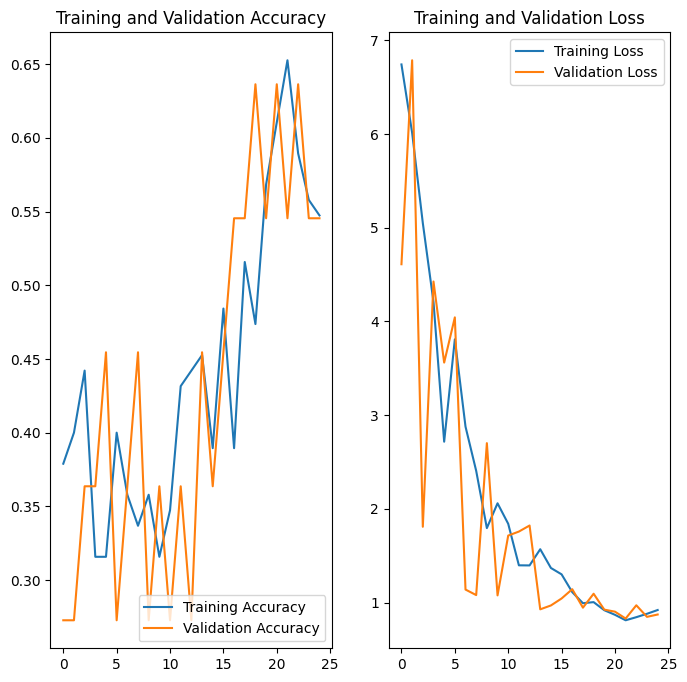

In [106]:
EPOCHS=25
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Resnet is not a good choice to go for

## Inception

In [188]:
inception= InceptionV3(input_shape=IMAGE_SIZE+[3], weights='imagenet',include_top=False)

In [189]:
for layer in inception.layers:
  layer.trainable = False

In [190]:
folders

['/content/drive/MyDrive/MyDrive/output/train/Bacterial leaf blight',
 '/content/drive/MyDrive/MyDrive/output/train/Leaf smut',
 '/content/drive/MyDrive/MyDrive/output/train/Brown spot']

In [191]:
x=Flatten()(inception.output)


In [192]:
prediction= Dense(len(folders),activation='softmax')(x)
model=Model(inputs=inception.input,outputs=prediction)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_305 (Conv2D)            (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_294 (Batch  (None, 111, 111, 32  96         ['conv2d_305[0][0]']             
 Normalization)                 )                                                           

In [193]:
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [182]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [200]:
history= model.fit(training_set, validation_data=val_set,
    epochs=30,
    batch_size=3,
    verbose=1,
    validation_steps=len(val_set),
#    callbacks=[callback]
)

Epoch 1/30
3/3 [==============================] - 20s 7s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.9407 - val_accuracy: 0.8182
Epoch 2/30
3/3 [==============================] - 18s 5s/step - loss: 1.8953e-04 - accuracy: 1.0000 - val_loss: 1.3025 - val_accuracy: 0.8182
Epoch 3/30
3/3 [==============================] - 18s 6s/step - loss: 0.0145 - accuracy: 0.9895 - val_loss: 1.3419 - val_accuracy: 0.8182
Epoch 4/30
3/3 [==============================] - 19s 6s/step - loss: 0.0083 - accuracy: 0.9895 - val_loss: 0.6994 - val_accuracy: 0.8182
Epoch 5/30
3/3 [==============================] - 19s 5s/step - loss: 0.0531 - accuracy: 0.9789 - val_loss: 0.4403 - val_accuracy: 0.8182
Epoch 6/30
3/3 [==============================] - 19s 6s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.2113 - val_accuracy: 0.9091
Epoch 7/30
3/3 [==============================] - 21s 8s/step - loss: 5.2775e-06 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9091
Epoch 8/30
3/3 [==========

In [201]:
   score= model.evaluate(testing_set)

1/1 [==============================] - 3s 3s/step - loss: 0.9596 - accuracy: 0.8462


In [202]:
score= model.evaluate(training_set)

3/3 [==============================] - 16s 5s/step - loss: 4.6520e-05 - accuracy: 1.0000


In [203]:
score= model.evaluate(val_set)

1/1 [==============================] - 2s 2s/step - loss: 0.0457 - accuracy: 1.0000


In [204]:
y_test=testing_set.labels
y_test
predict=model.predict(testing_set)
y_hat_inception=predict.argmax(axis=1)
y_hat_inception


1/1 [==============================] - 4s 4s/step


array([0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0])

1/1 [==============================] - 0s 162ms/step


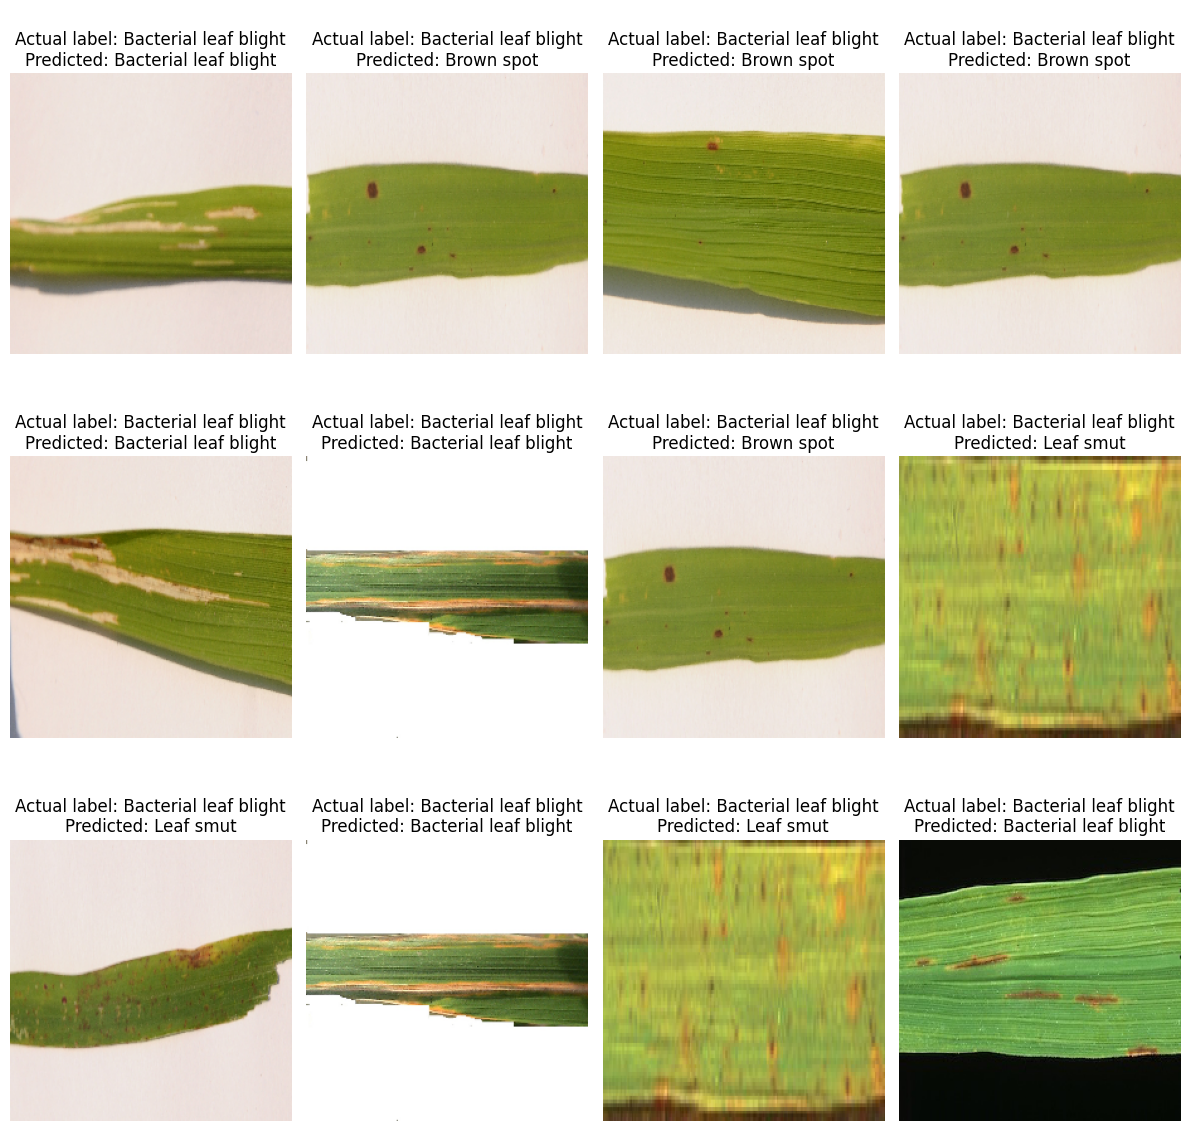

                       precision    recall  f1-score   support

Bacterial leaf blight       0.80      1.00      0.89         4
           Brown spot       1.00      1.00      1.00         4
            Leaf smut       1.00      0.75      0.86         4

             accuracy                           0.92        12
            macro avg       0.93      0.92      0.92        12
         weighted avg       0.93      0.92      0.92        12



In [205]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.figure(figsize=(12, 12))

true_labels = []  # To store the true labels
predicted_labels = []  # To store the predicted labels

for i, (images, labels) in enumerate(testing_set):
    if i == 12:
        break  # Break the loop after processing 9 images
    image = images[0]  # Assuming images is a batch of size 1
    image = np.squeeze(image)  # Remove the extra dimension
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    predicted = model.predict(image[np.newaxis, ...])
    predicted_class_index = np.argmax(predicted)
    predicted_class = class_map[predicted_class_index]
    true_class_index = np.argmax(labels[0]) 
    true_class = class_map[true_class_index]
    plt.title(f'\nActual label: {actual_class}\nPredicted: {predicted_class}')
    plt.axis('off')

    true_labels.append(true_class)
    predicted_labels.append(predicted_class)

plt.tight_layout()
plt.show()

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Print the classification report
print(classification_report(true_labels, predicted_labels))


In [206]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

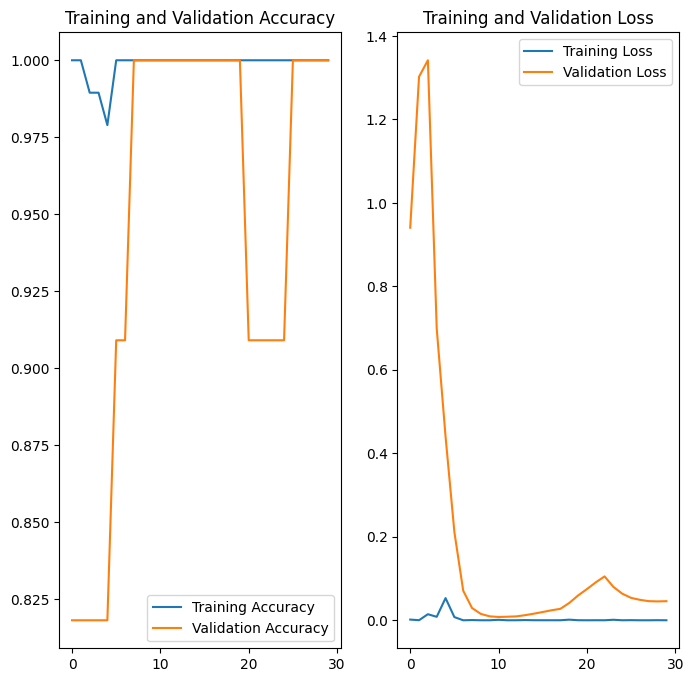

In [207]:
EPOCHS=30
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

we have very good accuracy for train and validation. However the test accuracy is only 85%

### Inception with AdaGrad

In [208]:
model.compile(optimizer='AdaGrad',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [210]:
history= model.fit(training_set, validation_data=val_set,
    epochs=10,
    batch_size=3,
    verbose=1,
    validation_steps=len(val_set),
#    callbacks=[callback]
)

Epoch 1/10
3/3 [==============================] - 20s 5s/step - loss: 3.4283e-04 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 18s 5s/step - loss: 3.6238e-06 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 19s 6s/step - loss: 1.2202e-04 - accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 19s 6s/step - loss: 1.0902e-04 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 22s 6s/step - loss: 1.5800e-05 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 19s 6s/step - loss: 1.6664e-06 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 19s 6s/step - loss: 2.7136e-05 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 

In [211]:
  score= model.evaluate(testing_set)

1/1 [==============================] - 2s 2s/step - loss: 0.7476 - accuracy: 0.9231


In [212]:
  score= model.evaluate(training_set)

3/3 [==============================] - 17s 4s/step - loss: 1.1440e-05 - accuracy: 1.0000


In [ ]:
  score= model.evaluate(val_set)

Text(0.5, 1.0, 'Training and Validation Loss')

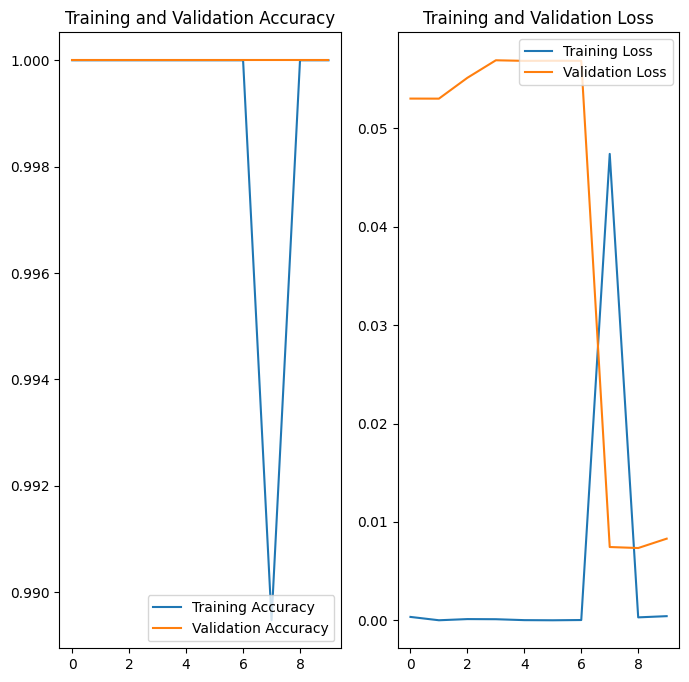

In [213]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

EPOCHS=10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [214]:
y_test=testing_set.labels
y_test
predict=model.predict(testing_set)
y_hat_inception=predict.argmax(axis=1)
y_hat_inception


1/1 [==============================] - 5s 5s/step


array([0, 2, 2, 0, 2, 1, 1, 0, 2, 2, 0, 1, 2])

1/1 [==============================] - 0s 190ms/step


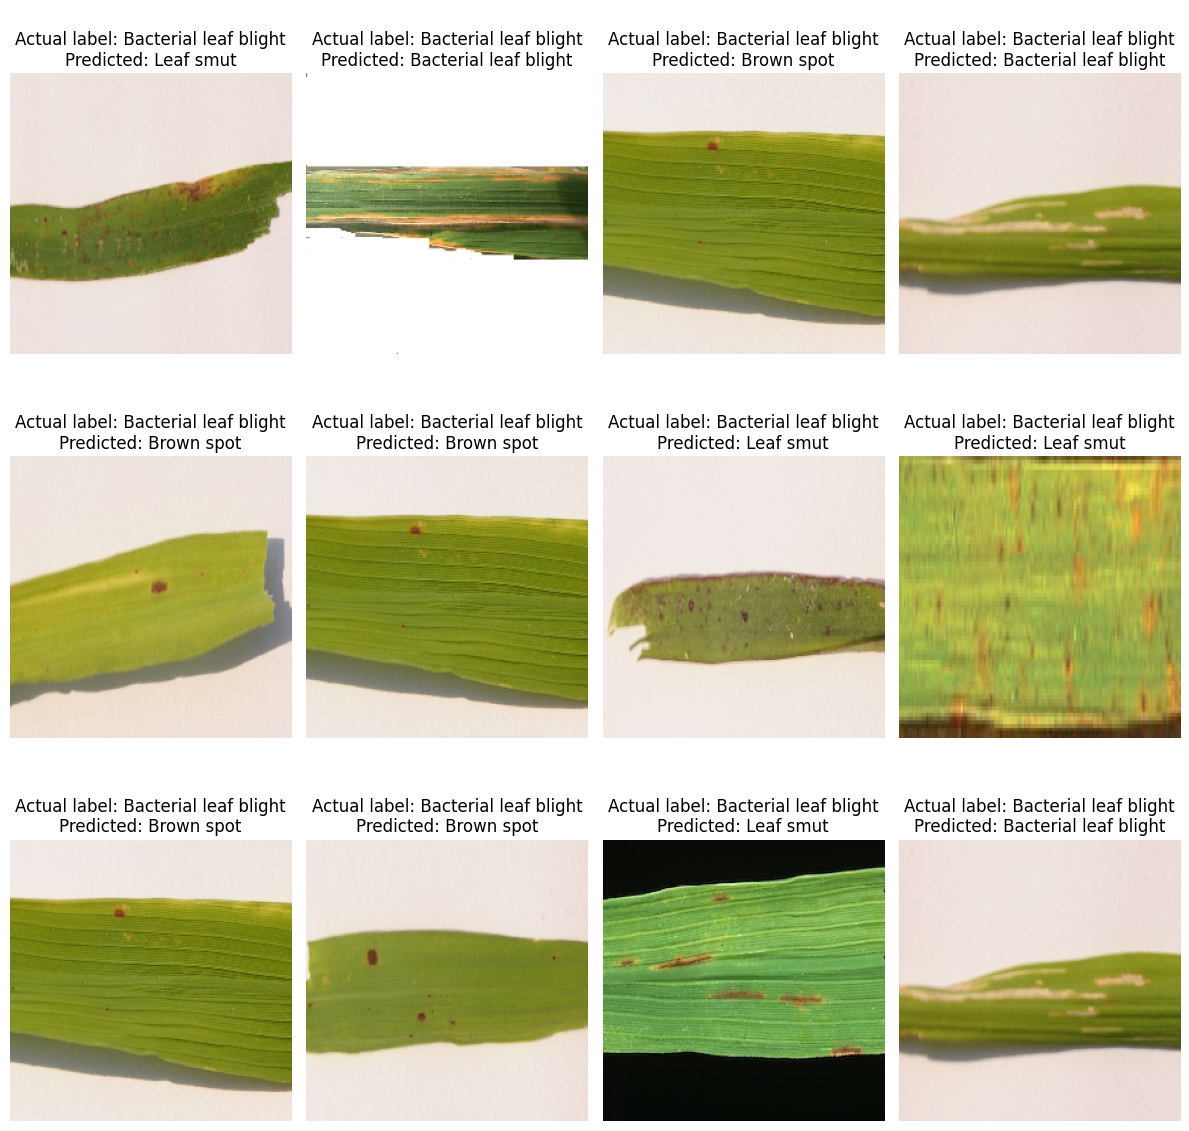

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         3
           Brown spot       1.00      1.00      1.00         5
            Leaf smut       1.00      1.00      1.00         4

             accuracy                           1.00        12
            macro avg       1.00      1.00      1.00        12
         weighted avg       1.00      1.00      1.00        12



In [215]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.figure(figsize=(12, 12))

true_labels = []  # To store the true labels
predicted_labels = []  # To store the predicted labels

for i, (images, labels) in enumerate(testing_set):
    if i == 12:
        break  # Break the loop after processing 9 images
    image = images[0]  # Assuming images is a batch of size 1
    image = np.squeeze(image)  # Remove the extra dimension
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    predicted = model.predict(image[np.newaxis, ...])
    predicted_class_index = np.argmax(predicted)
    predicted_class = class_map[predicted_class_index]
    true_class_index = np.argmax(labels[0]) 
    true_class = class_map[true_class_index]
    plt.title(f'\nActual label: {actual_class}\nPredicted: {predicted_class}')
    plt.axis('off')

    true_labels.append(true_class)
    predicted_labels.append(predicted_class)

plt.tight_layout()
plt.show()

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Print the classification report
print(classification_report(true_labels, predicted_labels))


Out of all the model, Inception with AdaGrad gave a great accuracy

## Xception

In [156]:
xception= Xception(input_shape=IMAGE_SIZE+[3], weights=None,include_top=False)

In [157]:
for layer in xception.layers:
  layer.trainable = False

In [158]:
x=Flatten()(xception.output)

In [159]:
prediction= Dense(len(folders),activation='softmax')(x)
model_xcpt=Model(inputs=xception.input,outputs=prediction)
model_xcpt.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [21]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

Adam optimizer

In [160]:
model_xcpt.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [161]:
history= model_xcpt.fit(training_set, validation_data=val_set,
    epochs=50,
    batch_size=3,
    verbose=1,
   # steps_per_epoch=len(training_set),
    validation_steps=len(val_set),callbacks=callback
)

Epoch 1/50
3/3 [==============================] - 37s 10s/step - loss: 1.0988 - accuracy: 0.2842 - val_loss: 1.0989 - val_accuracy: 0.2727
Epoch 2/50
3/3 [==============================] - 30s 9s/step - loss: 1.0987 - accuracy: 0.3263 - val_loss: 1.0989 - val_accuracy: 0.2727
Epoch 3/50
3/3 [==============================] - 32s 11s/step - loss: 1.0986 - accuracy: 0.3263 - val_loss: 1.0989 - val_accuracy: 0.2727
Epoch 4/50
3/3 [==============================] - 31s 11s/step - loss: 1.0987 - accuracy: 0.2737 - val_loss: 1.0986 - val_accuracy: 0.3636
Epoch 5/50
3/3 [==============================] - 31s 10s/step - loss: 1.0985 - accuracy: 0.3368 - val_loss: 1.0985 - val_accuracy: 0.3636
Epoch 6/50
3/3 [==============================] - 30s 11s/step - loss: 1.0984 - accuracy: 0.3368 - val_loss: 1.0984 - val_accuracy: 0.3636
Epoch 7/50
3/3 [==============================] - 31s 11s/step - loss: 1.0983 - accuracy: 0.3368 - val_loss: 1.0984 - val_accuracy: 0.3636
Epoch 8/50
3/3 [============

In [162]:
  score= model_xcpt.evaluate(testing_set)

1/1 [==============================] - 3s 3s/step - loss: 1.0998 - accuracy: 0.3077


In [163]:
score= model_xcpt.evaluate(training_set)

3/3 [==============================] - 27s 8s/step - loss: 1.0951 - accuracy: 0.4316


In [164]:
score= model_xcpt.evaluate(val_set)

1/1 [==============================] - 4s 4s/step - loss: 1.0956 - accuracy: 0.3636


In [165]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

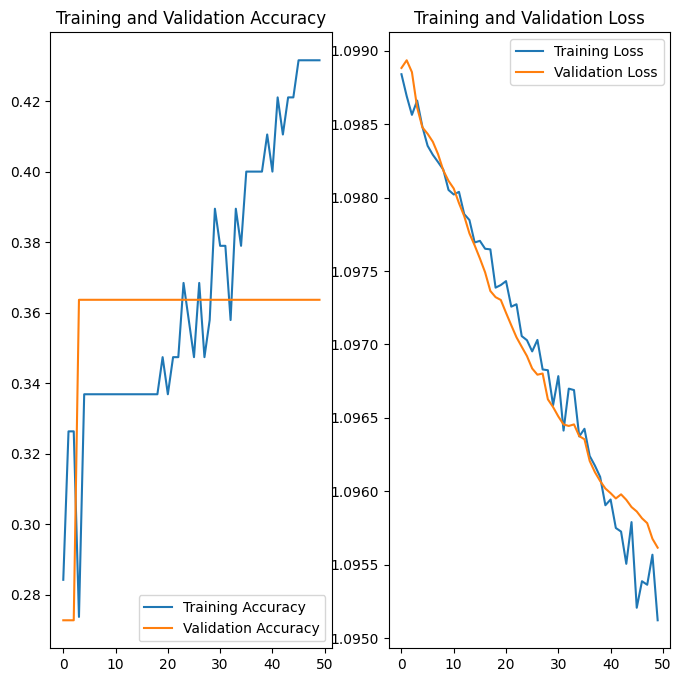

In [166]:
EPOCHS=50
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [167]:
y_test=testing_set.labels
y_test
predict=model_xcpt.predict(testing_set)
y_hat_inception=predict.argmax(axis=1)
y_hat_inception

1/1 [==============================] - 4s 4s/step


array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

1/1 [==============================] - 0s 251ms/step


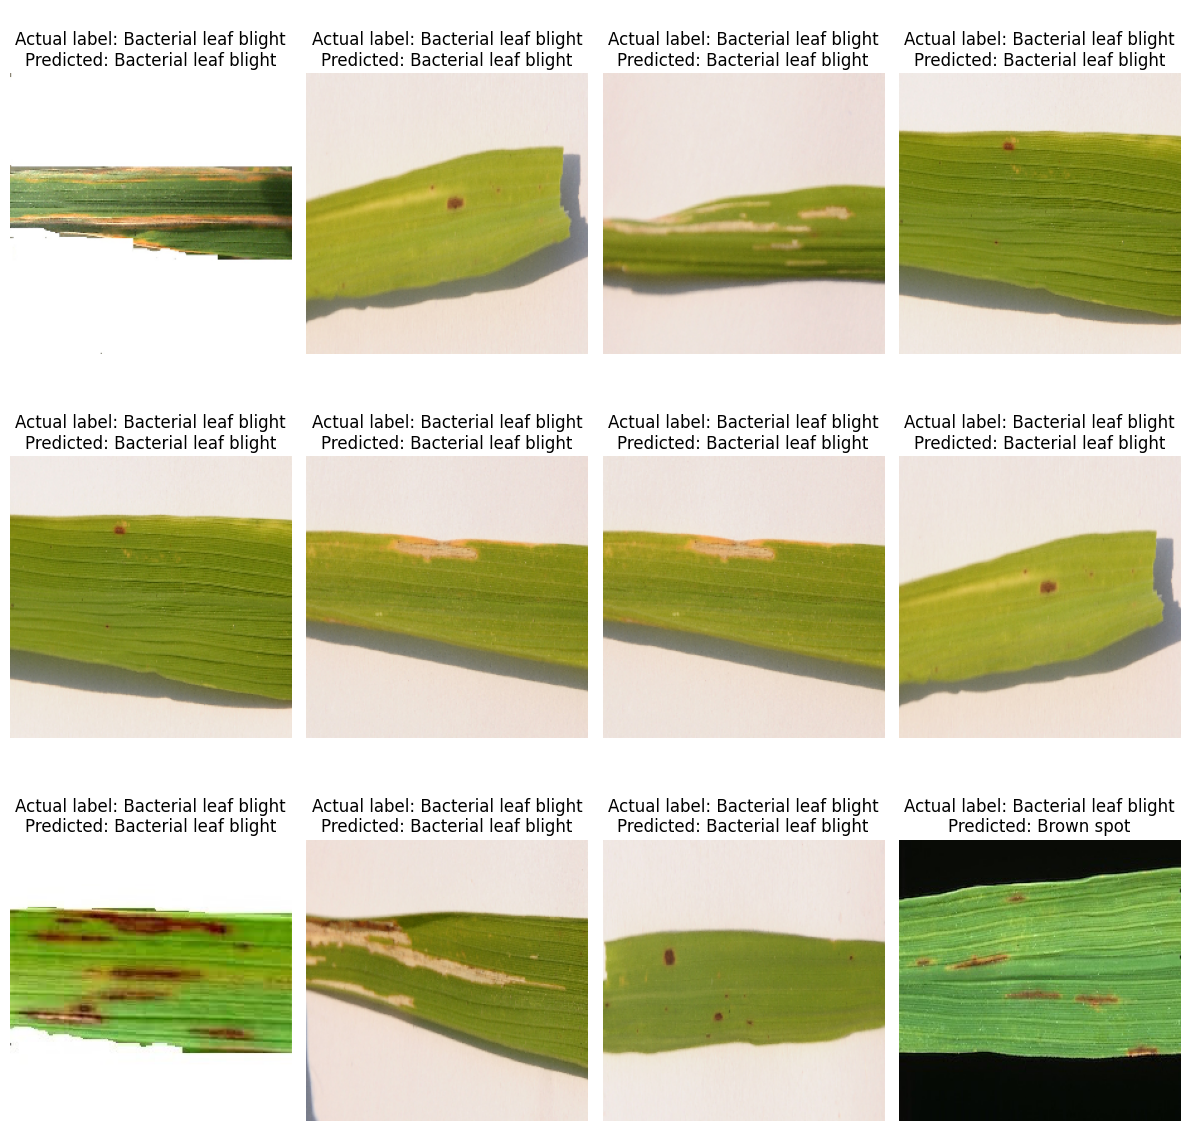

                       precision    recall  f1-score   support

Bacterial leaf blight       0.45      1.00      0.62         5
           Brown spot       0.00      0.00      0.00         5
            Leaf smut       0.00      0.00      0.00         2

             accuracy                           0.42        12
            macro avg       0.15      0.33      0.21        12
         weighted avg       0.19      0.42      0.26        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.figure(figsize=(12, 12))

true_labels = []  # To store the true labels
predicted_labels = []  # To store the predicted labels

for i, (images, labels) in enumerate(testing_set):
    if i == 12:
        break  # Break the loop after processing 9 images
    image = images[0]  # Assuming images is a batch of size 1
    image = np.squeeze(image)  # Remove the extra dimension
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    predicted = model_xcpt.predict(image[np.newaxis, ...])
    predicted_class_index = np.argmax(predicted)
    predicted_class = class_map[predicted_class_index]
    true_class_index = np.argmax(labels[0]) 
    true_class = class_map[true_class_index]
    plt.title(f'\nActual label: {actual_class}\nPredicted: {predicted_class}')
    plt.axis('off')

    true_labels.append(true_class)
    predicted_labels.append(predicted_class)

plt.tight_layout()
plt.show()

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Print the classification report
print(classification_report(true_labels, predicted_labels))

performance is very poor

## Xception with AdaGrad

In [169]:
model_xcpt.compile(optimizer='AdaGrad',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [173]:
history= model_xcpt.fit(training_set, validation_data=val_set,
    epochs=50,
    batch_size=3,
    verbose=1,
   # steps_per_epoch=len(training_set),
    validation_steps=len(val_set),callbacks=callback
)

Epoch 1/50
3/3 [==============================] - 31s 10s/step - loss: 1.0954 - accuracy: 0.4316 - val_loss: 1.0956 - val_accuracy: 0.3636
Epoch 2/50
3/3 [==============================] - 33s 11s/step - loss: 1.0950 - accuracy: 0.4421 - val_loss: 1.0956 - val_accuracy: 0.3636
Epoch 3/50
3/3 [==============================] - 31s 10s/step - loss: 1.0952 - accuracy: 0.4526 - val_loss: 1.0956 - val_accuracy: 0.3636
Epoch 4/50
3/3 [==============================] - 30s 9s/step - loss: 1.0954 - accuracy: 0.4211 - val_loss: 1.0956 - val_accuracy: 0.3636
Epoch 5/50
3/3 [==============================] - 32s 9s/step - loss: 1.0952 - accuracy: 0.4316 - val_loss: 1.0956 - val_accuracy: 0.3636
Epoch 6/50
3/3 [==============================] - 30s 9s/step - loss: 1.0952 - accuracy: 0.4316 - val_loss: 1.0956 - val_accuracy: 0.3636
Epoch 7/50
3/3 [==============================] - 33s 11s/step - loss: 1.0954 - accuracy: 0.4316 - val_loss: 1.0956 - val_accuracy: 0.3636
Epoch 8/50
3/3 [==============

In [174]:
score= model_xcpt.evaluate(testing_set)

1/1 [==============================] - 3s 3s/step - loss: 1.0998 - accuracy: 0.3077


In [175]:
score= model_xcpt.evaluate(training_set)

3/3 [==============================] - 27s 8s/step - loss: 1.0951 - accuracy: 0.4316


In [176]:
score= model_xcpt.evaluate(val_set)

1/1 [==============================] - 4s 4s/step - loss: 1.0956 - accuracy: 0.3636


In [218]:
y_test=testing_set.labels
y_test
predict=model_xcpt.predict(testing_set)
y_hat_inception=predict.argmax(axis=1)
y_hat_inception

1/1 [==============================] - 3s 3s/step


array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
class_map=training_set.class_indices
class_map=dict(zip(class_map.values(), class_map.keys()))
class_map

1/1 [==============================] - 0s 240ms/step


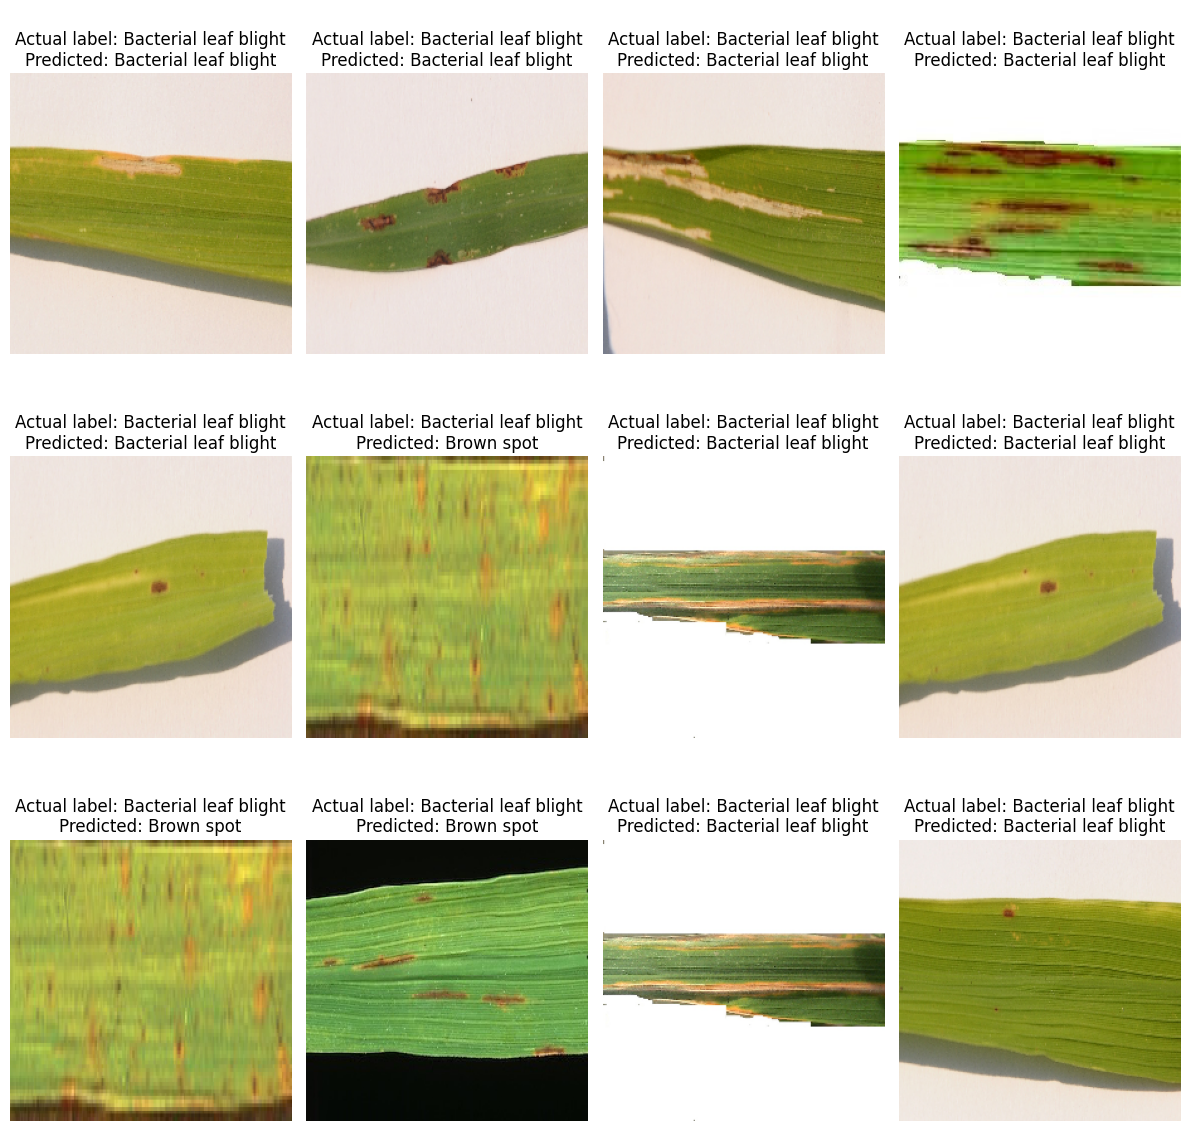

                       precision    recall  f1-score   support

Bacterial leaf blight       0.44      1.00      0.62         4
           Brown spot       0.00      0.00      0.00         4
            Leaf smut       0.00      0.00      0.00         4

             accuracy                           0.33        12
            macro avg       0.15      0.33      0.21        12
         weighted avg       0.15      0.33      0.21        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [219]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.figure(figsize=(12, 12))

true_labels = []  # To store the true labels
predicted_labels = []  # To store the predicted labels

for i, (images, labels) in enumerate(testing_set):
    if i == 12:
        break  # Break the loop after processing 9 images
    image = images[0]  # Assuming images is a batch of size 1
    image = np.squeeze(image)  # Remove the extra dimension
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    predicted = model_xcpt.predict(image[np.newaxis, ...])
    predicted_class_index = np.argmax(predicted)
    predicted_class = class_map[predicted_class_index]
    true_class_index = np.argmax(labels[0]) 
    true_class = class_map[true_class_index]
    plt.title(f'\nActual label: {actual_class}\nPredicted: {predicted_class}')
    plt.axis('off')

    true_labels.append(true_class)
    predicted_labels.append(predicted_class)

plt.tight_layout()
plt.show()

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Print the classification report
print(classification_report(true_labels, predicted_labels))

Nothing has changed even after using a different optimizer

## Conclusions

Out of all the models, inception model has performed really well when compared to CNN (with differnt layers and optimizers) and other transfer learning techniques.

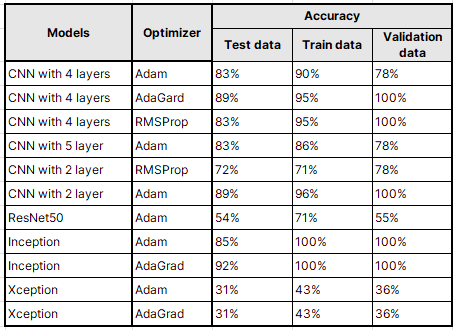


From the above, it is clear that Inception with AdaGrad optimizer performs better on train,test and validation datasets when compared to all the other models. Xception with Adam/ AdaGrad is the last model in the list that performs poorly with train, test and validation dataset.

Hence we are considering Inception AdaGrad as our final model 



### Challenges Faced:

We felt it initially hard to figure out how to work on image dataset and transfer learning techniques.

Considering the compute expenses, all the model trainings are done in google collab and the input datasets are extracted and maintained in the drive for easy access.

Also, it is observed that the testing accuracy in classification report is slightly different from that given by the evaluate() function and we understand that it is fair to have some deviation of that sought. 